# Exploratory non-linear analysis of NDVI data for South America

- Data from NASA/GSFC GIMMS NDVI3g version 1 1981-07-01 - 2015-12-31 1/12 x 1/12 degrees 1/24 a year.
- Only reggrided data (ERA-INTERIM grid).
- Find temporal and spatial occurrences of extreme values.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__) 

>>> Version of xarray: 0.13.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI/"

In [7]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [8]:
# Including regridded.
ALL_FILES_PATHS = sorted(glob.glob(DATA_FOLDER + "*.nc4"))

FILES_PATHS_REGRIDDED = []
for FILE_PATH in ALL_FILES_PATHS:

    # Excluding regridded.
    if "regridded" in FILE_PATH:
        FILES_PATHS_REGRIDDED.append(FILE_PATH)

In [9]:
%%time

# Lazy read of global data sets.
DS = xr.open_mfdataset(FILES_PATHS_REGRIDDED, concat_dim="time")

# South America.
DS = DS.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

CPU times: user 1.25 s, sys: 127 ms, total: 1.38 s
Wall time: 3.05 s


In [10]:
DS

<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 828)
Coordinates:
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * time       (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<chunksize=(12, 107, 81), meta=np.ndarray>

**DANGER ZONE:** LOAD DATA INTO MEMORY!

In [11]:
# Xarray DataArray object for NDVI.
DA = DS.ndvi

In [12]:
# Load into memory.
with ProgressBar():
    DA = DA.compute()

[########################################] | 100% Completed | 17.1s


## Preprocess data

In [13]:
# Scale factor and valid range of data [-0.3, 1.0].
DA = DA / 1e4
DA = DA.where(cond=(DA > -0.3), other=-0.3)
DA = DA.where(cond=(DA < 1.0), other=1.0)

# Make time coordinate as datetime.
time_values = pd.date_range(start="1981-07-01", end="2015-12-31", periods=DA.time.size)
DA["time"] = time_values

In [14]:
# Land mask at ERA-INTERIM grid.
DA = cdlearn.pixels.EraInterimGrid.add_land_mask(DA)

In [15]:
# Anomalies.
DA_ano = cdlearn.statistics.anomalies(DA)

## Time occurrence of extremes.

Observed data as well as anomalies.

In [16]:
# Integer index for time occurrence of min and max.
imin = DA.where(DA.land_mask == True, other=-9999.9).argmin(dim="time", skipna=True)
imax = DA.where(DA.land_mask == True, other=-9999.9).argmax(dim="time", skipna=True)
imin_ano = DA_ano.where(DA_ano.land_mask == True, other=-9999.9).\
                  argmin(dim="time", skipna=True)
imax_ano = DA_ano.where(DA_ano.land_mask == True, other=-9999.9).\
                  argmax(dim="time", skipna=True)

In [17]:
# Extremes.
EXTs = [DA.time.dt.year[index] for index in [imin, imax]] + \
       [DA_ano.time.dt.year[index] for index in [imin_ano, imax_ano]]
titles = ["Mínimos observados", "Máximos observados",
          "Mínimos de anomalia", "Máximos de anomalia"]

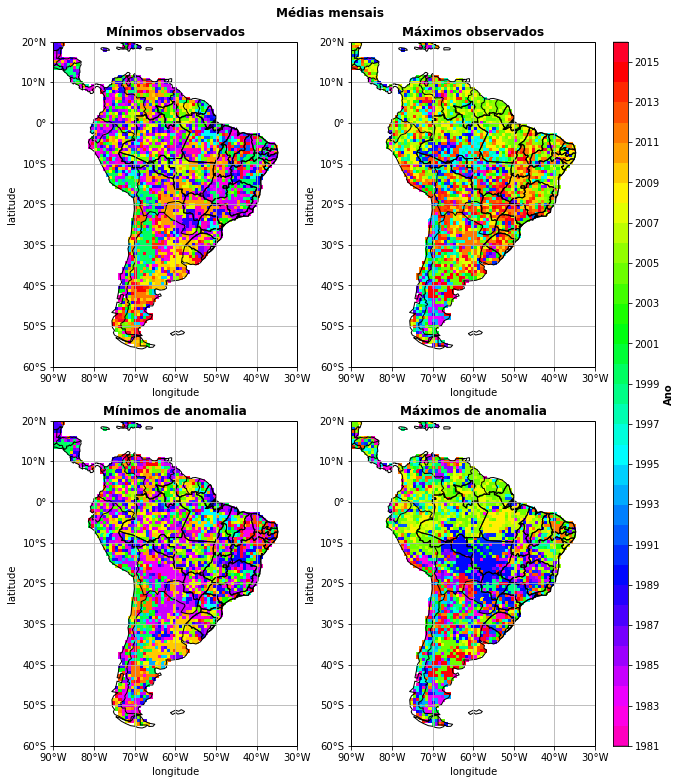

In [18]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).plot(
        ax=axis,
        vmin=1981,
        vmax=2015,
        levels=np.arange(1981, 2017, 1),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Ano", weight="bold")
cb.cbar_axis.set_ticks(np.arange(1981, 2017, 2))
plt.suptitle("Médias mensais", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_mm_obs_ano_pt.jpg", dpi=200, 
            bbox_inches="tight")       

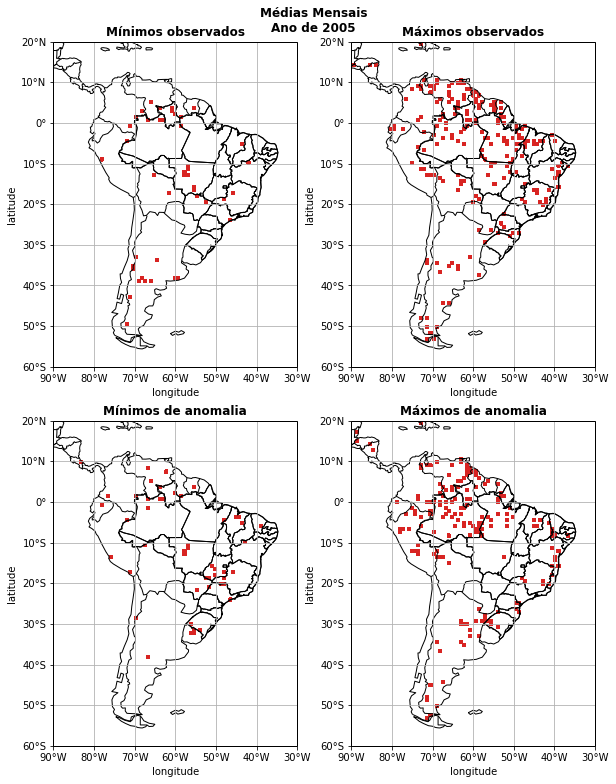

In [19]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode=None,
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).\
                    where(EXTs[index].time.dt.year == 2005).\
                    plot(
                    ax=axis,
                    vmin=1981,
                    vmax=2015,
                    levels=np.arange(1981, 2017, 1),
                    cmap=plt.cm.Reds,
                    add_colorbar=False,
                    add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

plt.suptitle("Médias Mensais\nAno de 2005", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_mm_obs_ano_2005_pt.jpg", dpi=200, 
            bbox_inches="tight")

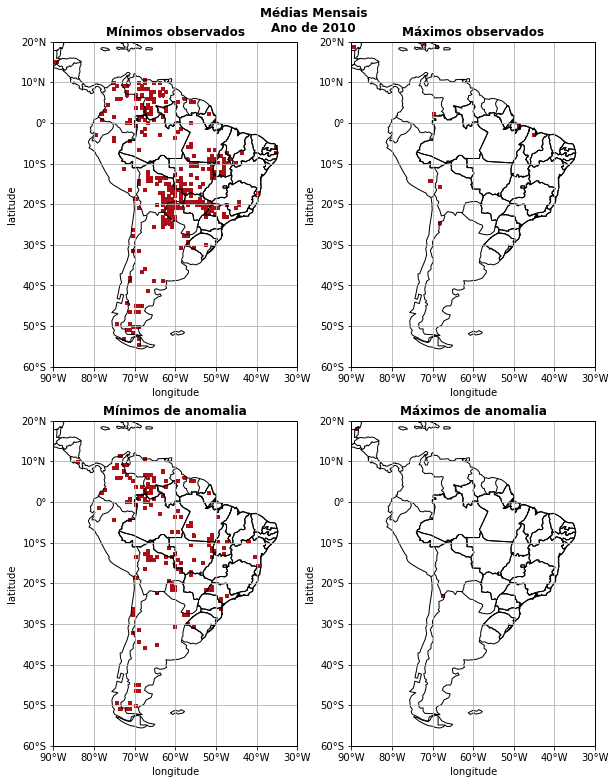

In [20]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode=None,
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).\
                    where(EXTs[index].time.dt.year == 2010).\
                    plot(
                    ax=axis,
                    vmin=1981,
                    vmax=2015,
                    levels=np.arange(1981, 2017, 1),
                    cmap=plt.cm.Reds,
                    add_colorbar=False,
                    add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

plt.suptitle("Médias Mensais\nAno de 2010", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_mm_obs_ano_2010_pt.jpg", dpi=200, 
            bbox_inches="tight")

In [21]:
# Extremes for annual means. Exclude the incomplete first year.
DA_am = DA.sel(time=slice("1982", "2015")).groupby("time.year").mean("time")
DA_am_ano = DA_ano.sel(time=slice("1982", "2015")).groupby("time.year").mean("time")

# Integer index for time occurrence of min and max.
imin = DA_am.where(DA_am.land_mask == True, other=-9999.9).argmin(dim="year", skipna=True)
imax = DA_am.where(DA_am.land_mask == True, other=-9999.9).argmax(dim="year", skipna=True)
imin_ano = DA_am_ano.where(DA_am_ano.land_mask == True, other=-9999.9).\
                     argmin(dim="year", skipna=True)
imax_ano = DA_am_ano.where(DA_am_ano.land_mask == True, other=-9999.9).\
                     argmax(dim="year", skipna=True)

# Extremes.
EXTs = [DA_am.year[index] for index in [imin, imax]] + \
       [DA_am_ano.year[index] for index in [imin_ano, imax_ano]]
titles = ["Mínimos observados", "Máximos observados",
          "Mínimos de anomalia", "Máximos de anomalia"]

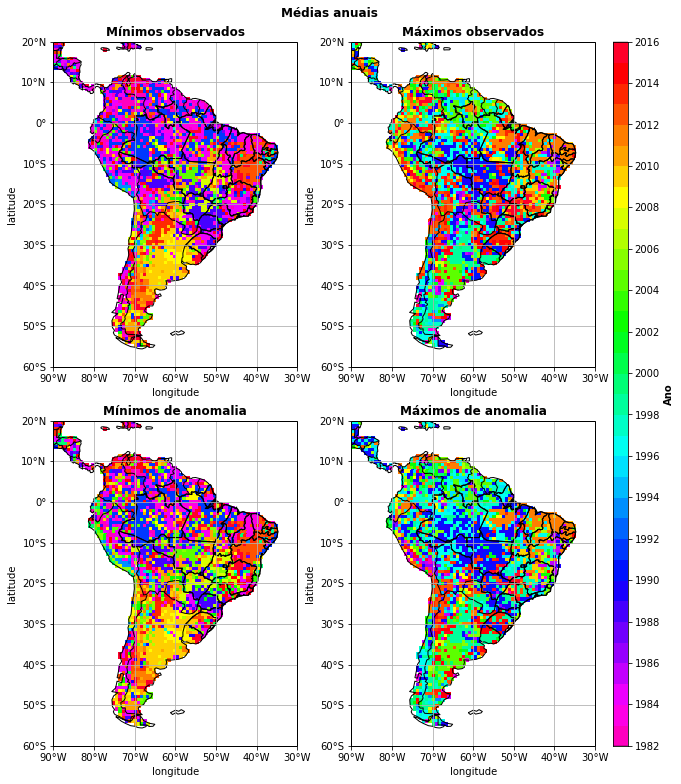

In [22]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).plot(
        ax=axis,
        vmin=1982,
        vmax=2015,
        levels=np.arange(1982, 2017, 1),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Ano", weight="bold")
cb.cbar_axis.set_ticks(np.arange(1982, 2017, 2))
plt.suptitle("Médias anuais", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_am_obs_ano_pt.jpg", dpi=200, 
            bbox_inches="tight")

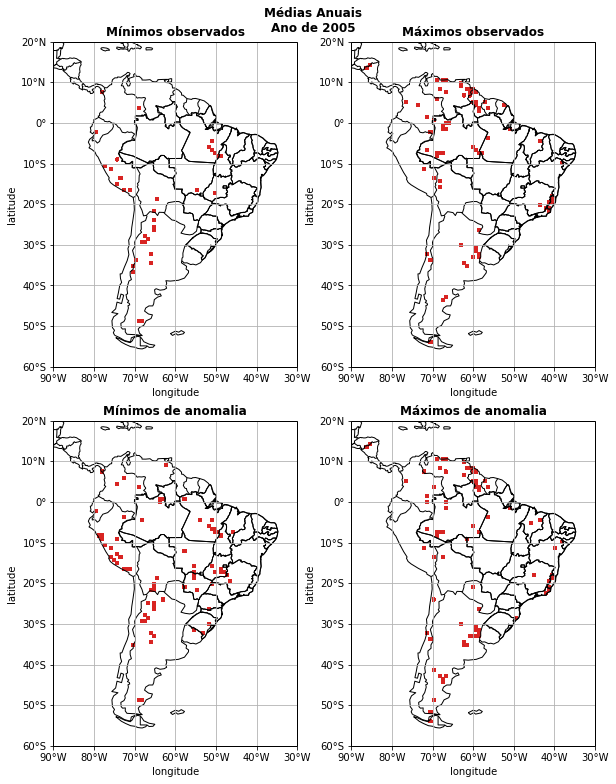

In [23]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode=None,
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).\
                    where(EXTs[index].year == 2005).\
                    plot(
                    ax=axis,
                    vmin=1981,
                    vmax=2015,
                    levels=np.arange(1981, 2017, 1),
                    cmap=plt.cm.Reds,
                    add_colorbar=False,
                    add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

plt.suptitle("Médias Anuais\nAno de 2005", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_am_obs_ano_2005_pt.jpg", dpi=200, 
            bbox_inches="tight")

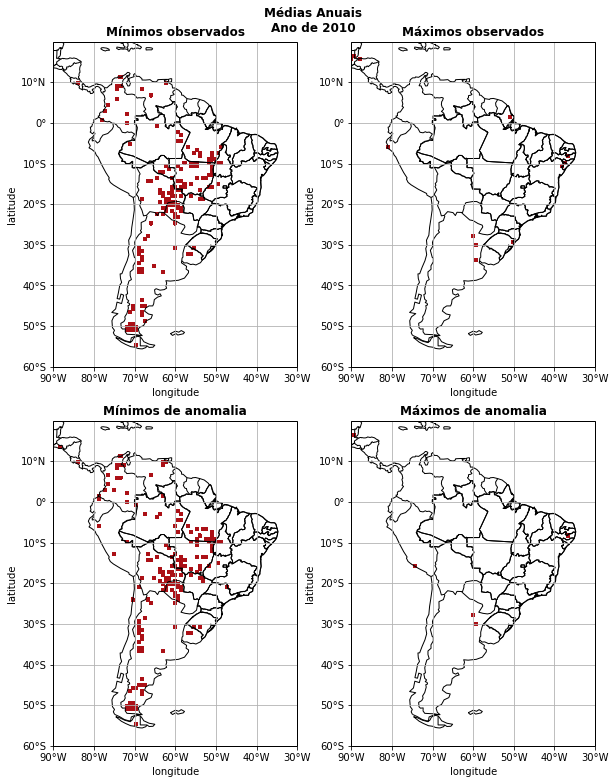

In [24]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.75,
                cbar_location="right",
                cbar_mode=None,
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 20, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines()

    # Plot data on these maps.
    p = EXTs[index].where(EXTs[index].land_mask==True).\
                    where(EXTs[index].year == 2010).\
                    plot(
                    ax=axis,
                    vmin=1982,
                    vmax=2015,
                    levels=np.arange(1981, 2017, 1),
                    cmap=plt.cm.Reds,
                    add_colorbar=False,
                    add_labels=True)
    
    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

plt.suptitle("Médias Anuais\nAno de 2010", weight="bold")
plt.subplots_adjust(top=0.94)

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_extremes_am_obs_ano_2010_pt.jpg", dpi=200, 
            bbox_inches="tight")